Article: Joanna H. Shih and Thomas A. Louis: "Inferences on the Association Parameter in Copula Models for Bivariate Survival Data", Biometrics
Vol. 51, No. 4, Dec., 1995

Install R into Python (to be able to use copula package)

In [ ]:
!sudo apt install libgsl-dev
!pip install rpy2
%reload_ext rpy2.ipython

Packages

In [ ]:
%%R
install.packages(c('copula','pracma','SurvCorr','survival','MASS'))# 'tabulizer','tryCatchLog','mhazard','CASdatasets'
library(copula) # for claytonCopula
library(survival) # univariate Kaplan-Meier estimators, kidney data
library(pracma) # for NewtonRaphson procedure
#library(tryCatchLog) # errors and warnings management
library(MASS) # for ginv
#library(CASdatasets)

Functions definition

In [ ]:
%%R
FunZDel = function(n,theta,lambda=lambda,alpha=2,beta=2){#,seed
  
  require(copula)
  require(survival)
  
  MyCopula <- mvdc(copula=claytonCopula(param=theta), # Clayton copula for (F(X), F(Y))
                    margins=c("weibull","weibull"), # Weibull distribution for margins X and Y
                    paramMargins=list(shape=alpha,scale=beta)) # alpha:shape, beta:scale

  #set.seed(seed)
  XY <- rMvdc(n=n,MyCopula)
  X <- XY[,1]
  Y <- XY[,2]

  # Censoring variable

  Cx = rexp(n=n,rate = lambda)
  Cy = rexp(n=n,rate = lambda)

  # Observations

  Z1 <- pmin(X,Cx)
  Z2 <- pmin(Y,Cy)

  ordre = order(Z1,Z2)

  xinf=max(Z1,Z2)+1 # point at infinity
  Z1=c(Z1[ordre],xinf)
  Z2=c(Z2[ordre],xinf)

  del1 = as.integer(X <= Cx)
  del2 = as.integer(Y <= Cy)

  del1=del1[ordre]
  del2=del2[ordre]

  del1=c(del1,1)
  del2=c(del2,1)
  del=del1*del2
  #del=del[ordre]
  
  return(list(Z1,Z2,del1,del2))
}

Fun_ThetaHatFn12 <- function(Z1,Z2,del1,del2,n,phat,Fbar){
  
  del = del1*del2

  # Starting point of Newton-Raphson
  
  Tau_hat = 4*(t(phat) %*% Fbar)-1
  Theta0 = 2*Tau_hat/(1-Tau_hat) # Clayton
  #Theta0 = 1+4(incgam(3,1.2)/)
  
  #s = 10**(-3)
  
  # # # MLE of theta
  
  # # Fn1
  
  # az1=matrix(rep(Z1,n+1),ncol=n+1)
  # A=t(az1)>=az1
  
  # A[lower.tri(A, diag = FALSE)] = 0
  # rsumA=apply(A,1,sum)
  
  # b=c((1-eps)*del[1:n]/((1-eps)*(rsumA[1:n]-1)+eps*n),1)
  # B=diag(b)
  
  # Id = diag(1,n+1)
  
  # M=rbind(Id-A%*%B,-t(b))
  # MMinv=solve(t(M)%*%M)
  # Fn1bar=as.vector(MMinv%*%b) # Fn1 bar
  # Fn1 = 1-Fn1bar # Fn1
  # #Fn1[Fn1 < s]=s # too small values will yield infinity when inverted
  
  # # Fn2
  
  # Z2_ordered = Z2[order(Z2)]
  # az2=matrix(rep(Z2_ordered,n+1),ncol=n+1)
  # A=t(az2)>=az2
  
  # A[lower.tri(A, diag = FALSE)] = 0
  # rsumA=apply(A,1,sum)
  
  # del2 = del[order(Z2)]
  # b=c((1-eps)*del2[1:n]/((1-eps)*(rsumA[1:n]-1)+eps*n),1)
  # B=diag(b)
  
  # M=rbind(Id-A%*%B,-t(b))
  # MMinv=solve(t(M)%*%M)
  # Fn2bar=as.vector(MMinv%*%b)
  # Fn2 = 1-Fn2bar
  # #Fn2[Fn2 < s]=s
  
  # # MLE estimate of theta
  # # theta_hat[i] = optimise(f=LogL,interval=c(0,10**2),maximum = TRUE)$maximum
  
  # Fn1=Fn1[-(n+1)]
  # Fn2=Fn2[-(n+1)]

  Fn1bar <- survfit(Surv(Z1, del1) ~ 1)$surv
  Fn1 <- 1-Fn1bar#*n/(n+1)
  Fn2bar <- survfit(Surv(Z2, del2) ~ 1)$surv
  Fn2 <- 1-Fn2bar#*n/(n+1)
  
  # Log-pseudo-likelihood function derivative aka score function
  DiffLogL = function(x){ # Clayton
    #x = 10
    sum(phat*(rep(1/(x+1),times=n)-
                log(Fn1*Fn2)+
                (rep(1/x**2,times=n))*log(Fn1**(rep(-x,times=n))+Fn2**(rep(-x,times=n))-1)+
                (rep(2+1/x,times=n))*(Fn1**(rep(-x,times=n))*log(Fn1)+ 
                # this last term (the line above + the 2 below) has limit log(a)(log(b)+2)+2log(b)
                                             Fn2**(rep(-x,times=n))*log(Fn2))/
                                      (Fn1**(rep(-x,times=n))+Fn2**(rep(-x,times=n))-1)),na.rm=TRUE)

    #term1 = suppressWarnings(log(Fn1*Fn2))
    #term1[is.na(term1)] = -10**6# min(term1[!is.na(term1)])-100
    #term2 = suppressWarnings((rep(1/x**2,times=n))*log(Fn1**(rep(-x,times=n))+Fn2**(rep(-x,times=n))-1)+
    #  (rep(2+1/x,times=n))*(Fn1**(rep(-x,times=n))*log(Fn1)+
    #                                Fn2**(rep(-x,times=n))*log(Fn2))/
    #                      (Fn1**(rep(-x,times=n))+Fn2**(rep(-x,times=n))-1))
    # term2+term3 has limit log(a)(log(b)+2)+2log(b)
    #term2[is.na(term2)] = -10**6# min(term3[!is.na(term3)])-100
    
    #return(sum(phat*(rep(1/(x+1),times=n)-term1+term2)))
    #return(na.omit(result))
   }

  # Log-full-likelihood function derivative
  DiffLogLStar = function(x){ # Clayton
    #x = 10
    sum(del1*del2*(rep(1/(x+1),times=n)-log(Fn1*Fn2))-
                (del1*(1-del2)*log(Fn1)+(1-del1)*del2*log(Fn2))-
                (
                  -rep(1/x**2,times=n)*(1-del1*del2)*log(Fn1**(rep(-x,times=n))+Fn2**(rep(-x,times=n))-1)+
                  (rep(1/x,times=n)*(1-del1*del2)+del1+del2-2*del1*del2)*((-Fn1**(rep(-x,times=n))*log(Fn1)-Fn2**(rep(-x,times=n))*log(Fn2))/(Fn1**(rep(-x,times=n))+Fn2**(rep(-x,times=n))-1))
                )
                ,na.rm=TRUE)
    }
    
  #X=matrix(seq(from=0,to=15,by=0.01)); ForPlot=apply(X=X,MARGIN=1,FUN=DiffLogL);
  #plot(X,ForPlot,type='l',ylim=range(c(ForPlot,0)));abline(h=0);
  
  #  DiffLogL = function(x){ # 4.2.20 Nelsen
  #    (-1/x)*sum(phat*((-exp(Fn1**(-rep(-x,times=n)))*Fn1**(-rep(-x,times=n))*log(Fn1)-exp(Fn2**(-rep(-x,times=n)))*Fn2**(-rep(-x,times=n))*log(Fn2))/
  #      ((exp(Fn1**(-rep(-x,times=n)))+exp(Fn2**(-rep(-x,times=n)))-exp(1))*log(exp(Fn1**(-rep(-x,times=n)))+exp(Fn2**(-rep(-x,times=n)))-exp(1)))))
  #  }
  
  #theta_hat <- nlm(f=DiffLogL, p=Theta0)$estimate # not working
  #theta_hat <- newtonRaphson(fun=DiffLogL, x0=Theta0)$root 
  theta_hat_MassShift = uniroot(f=DiffLogL, interval=c(0.01,15))$root # more realistic values
  #theta_hat_ShihLouis = uniroot(f=DiffLogLStar, interval=c(0.01,15))$root # not working
  theta_hat_ShihLouis  <- nlm(f=DiffLogLStar, p=Theta0)$estimate
  #theta_hat  <- nlm(f=DiffLogL, p=Theta0)$estimate
  
  # Coding Newton-Raphson:
  # https://rpubs.com/aaronsc32/newton-raphson-method#:~:text=%23%23%20%5B1%5D%203.162278-,Newton%2DRaphson%20Method%20in%20R,rootSolve%20package%20features%20the%20uniroot.
  
  return(list(theta_hat_MassShift,theta_hat_ShihLouis,Fn1,Fn2))#
} 

FunZDel_canlifins = function(size,seed=1){
  
  #data(canlifins) # load the dataset
  canlifins <- get(load('/content/canlifins.rda'))
  # 14,889 contracts where one annuitant is male and the other female
  
  canlifins = canlifins[(canlifins$EntryAgeM>=18)|(canlifins$EntryAgeF>=18),]
  
  set.seed(seed)
  Sample = sample(1:dim(canlifins)[1],size = size)
  canlifins = canlifins[Sample,]
  
  #  c(
  #    sum((canlifins$DeathTimeM == 0) & (canlifins$DeathTimeF == 0)), # number of doubly censored couples
  #    sum((canlifins$DeathTimeM > 0) & (canlifins$DeathTimeF == 0)), # number of couples where only the woman is censored
  #    sum((canlifins$DeathTimeM == 0) & (canlifins$DeathTimeF > 0)), # number of couples where only the man is censored
  #    sum((canlifins$DeathTimeM > 0) & (canlifins$DeathTimeF > 0)) # number of doubly uncensored couples
  #  )
  
  #del1 = as.integer((canlifins$DeathTimeM > 0) & (canlifins$DeathTimeF == 0)) 
  #del2 = as.integer((canlifins$DeathTimeM == 0) & (canlifins$DeathTimeF > 0))
  
  del1=canlifins$DeathTimeM > 0
  del2=canlifins$DeathTimeF > 0
  
  #del = (canlifins$DeathTimeM > 0) * (canlifins$DeathTimeF > 0)

  ordre = order(canlifins$DeathTimeM+canlifins$EntryAgeM,canlifins$DeathTimeF+canlifins$EntryAgeF)
  Z_ordered = cbind(canlifins$DeathTimeM+canlifins$EntryAgeM,canlifins$DeathTimeF+canlifins$EntryAgeF)[ordre,]
  
  del1=c(del1[ordre],1)
  del2=c(del2[ordre],1)
  
  xinf=max(Z_ordered[,1],Z_ordered[,2])+1
  Z1=c(Z_ordered[,1],xinf)
  Z2=c(Z_ordered[,2],xinf)
  
  return(list(Z1,Z2,del1,del2))
}

Fun_VarMLE <- function(Z1,Z2,del,theta_hat,Fn1,Fn2,n){
  
  # # Variance of An
  
  # Phi
  
  Phi = rep(1/(theta_hat+1),times=n)-
    log(Fn1*Fn2)+
    rep(1/theta_hat**2,times=n)*log(Fn1**rep(-theta_hat,times=n)+Fn2**rep(-theta_hat,times=n)-1)-
    rep(2+1/theta_hat,times=n)*(-Fn1**rep(-theta_hat,times=n)*log(Fn1)-Fn2**rep(-theta_hat,times=n)*log(Fn2))/(Fn1**rep(-theta_hat,times=n)+Fn2**rep(-theta_hat,times=n)-1)
  
  # VStar
  
  az1=matrix(rep(Z1,n+1),ncol=n+1)
  A=(t(az1)>=az1)
  A[lower.tri(A, diag = FALSE)] = 0
  rsumA=apply(A,1,sum)
  
  b=c((1-eps)*del[1:n]/((1-eps)*(rsumA[1:n]-1)+eps*n),1)
  B=diag(b)
  
  Id = diag(1,n+1)
  
  M=rbind(Id-A%*%B,-t(b))
  MMinv=solve(t(M)%*%M)
  Fbar=as.vector(MMinv%*%b)
  
  Fbar=Fbar[-(n+1)]
  b=b[-(n+1)]
  A=A[-(n+1),][,-(n+1)]
  B=B[-(n+1),][,-(n+1)]
  Id=diag(1,n)
  M=rbind(Id-A%*%B,-t(b))
  MMinv=solve(t(M)%*%M)
  
  D=(1-A)*(1-t(A))*(A%*%t(A))
  bf=b*Fbar
  BF=diag(bf)
  S=rbind(A%*%BF,t(bf))
  R=S%*%(Id+((B%*%D)%*%B))%*%t(S)
  U=(t(M)%*%R)%*%M
  V_z0=(MMinv%*%U)%*%MMinv
  
  Z2_ordered = Z2[order(Z2)]
  az2=matrix(rep(Z2_ordered,n+1),ncol=n+1)
  A=(t(az2)>=az2)
  A[lower.tri(A, diag = FALSE)] = 0
  rsumA=apply(A,1,sum)
  
  del2 = del[order(Z2)]
  
  b=c((1-eps)*del2[1:n]/((1-eps)*(rsumA[1:n]-1)+eps*n),1)
  B=diag(b)
  Id=diag(1,n+1)
  
  M=rbind(Id-A%*%B,-t(b))
  MMinv=solve(t(M)%*%M)
  Fbar=as.vector(MMinv%*%b)
  
  Fbar=Fbar[-(n+1)]
  b=b[-(n+1)]
  A=A[-(n+1),][,-(n+1)]
  B=B[-(n+1),][,-(n+1)]
  Id=diag(1,n)
  M=rbind(Id-A%*%B,-t(b))
  MMinv=solve(t(M)%*%M)
  
  D=(1-A)*(1-t(A))*(A%*%t(A))
  bf=b*Fbar
  BF=diag(bf)
  S=rbind(A%*%BF,t(bf))
  R=S%*%(Id+((B%*%D)%*%B))%*%t(S)
  U=(t(M)%*%R)%*%M
  V_0z=(MMinv%*%U)%*%MMinv
  
  Fun_PhiStar <- function(x,y,theta){
    -1/x-
      rep(1/theta,times=n)*x**rep(-theta-1,times=n)/(x**rep(-theta,times=n)+y**rep(-theta,times=n)-1)+
      rep(2+1/theta,times=n)*x**rep(-theta-1,times=n)*((x**rep(-theta,times=n)+y**rep(-theta,times=n)-1)*(-rep(theta,times=n)*log(x)+1)+
                                                         rep(theta,times=n)*(x**rep(-theta,times=n)*log(x)+y**rep(-theta,times=n)*log(y)))/
      (x**rep(-theta,times=n)+y**rep(-theta,times=n)-1)**2
    }
  
  #PhiStar1  = -1/Fn1-
  #  rep(1/theta_hat,times=n)*Fn1**rep(-theta_hat-1,times=n)/(Fn1**rep(-theta_hat,times=n)+Fn2**rep(-theta_hat,times=n)-1)+
  #  rep(2+1/theta_hat,times=n)*Fn1**rep(-theta_hat-1,times=n)*((Fn1**rep(-theta_hat,times=n)+Fn2**rep(-theta_hat,times=n)-1)*(-rep(theta_hat,times=n)*log(Fn1)+1)+
  #                                                               rep(theta_hat,times=n)*(Fn1**rep(-theta_hat,times=n)*log(Fn1)+Fn2**rep(-theta_hat,times=n)*log(Fn2)))/
  #  (Fn1**rep(-theta_hat,times=n)+Fn2**rep(-theta_hat,times=n)-1)**2
  
  PhiStar1 = Fun_PhiStar(x=Fn1,y=Fn2,theta=theta_hat)
  PhiStar2 = Fun_PhiStar(x=Fn2,y=Fn1,theta=theta_hat)
  
  #PhiStar2  = -1/Fn2-
  #  rep(1/theta_hat,times=n)*Fn2**rep(-theta_hat-1,times=n)/(Fn1**rep(-theta_hat,times=n)+Fn2**rep(-theta_hat,times=n)-1)+
  #  rep(2+1/theta_hat,times=n)*Fn2**rep(-theta_hat-1,times=n)*((Fn1**rep(-theta_hat,times=n)+Fn2**rep(-theta_hat,times=n)-1)*(-rep(theta_hat,times=n)*log(Fn2)+1)+
  #                                                               rep(theta_hat,times=n)*(Fn1**rep(-theta_hat,times=n)*log(Fn1)+Fn2**rep(-theta_hat,times=n)*log(Fn2)))/
  #  (Fn1**rep(-theta_hat,times=n)+Fn2**rep(-theta_hat,times=n)-1)**2
  
  #PhiStar1[is.nan(PhiStar1)] <- 0
  #PhiStar2[is.nan(PhiStar2)] <- 0
  
  PhiStar1_matrix = matrix(rep(PhiStar1,times=n),ncol=n)
  PhiStar2_matrix = matrix(rep(PhiStar2,times=n),ncol=n)
  
  VStar = V_z0*PhiStar1_matrix + V_0z*PhiStar2_matrix
  
  # R_hat
  
  az1=matrix(rep(Z1,n+1),ncol=n+1)
  az2=matrix(rep(Z2,n+1),ncol=n+1)
  A=(t(az1)>=az1)*(t(az2)>=az2)
  A[lower.tri(A, diag = FALSE)] = 0
  rsumA=apply(A,1,sum)
  
  b=c((1-eps)*del[1:n]/((1-eps)*(rsumA[1:n]-1)+eps*n),1)
  B=diag(b)
  
  Id=diag(rep(1,n+1))
  M=rbind(Id-A%*%B,-t(b))
  MMinv=solve(t(M)%*%M)
  Fbar=as.vector(MMinv%*%b)
  
  Fbar=Fbar[-(n+1)]
  b=b[-(n+1)]
  A=A[-(n+1),][,-(n+1)]
  B=B[-(n+1),][,-(n+1)]
  Id=diag(1,n)
  M=rbind(Id-A%*%B,-t(b))
  MMinv=solve(t(M)%*%M)
  
  D=(1-A)*(1-t(A))*(A%*%t(A))
  
  Matrix1 = rbind(Id - A%*%B,-t(b))
  
  #Matrix3 = (rbind(A%*%B%*%diag(Fbar),b%*%diag(Fbar)))%*%(Id + B%*%D%*%B)%*%(diag(Fbar)%*%B%*%(Phi*PhiStar1))
  Matrix3 = (rbind(A%*%B%*%diag(Fbar),b%*%diag(Fbar)))%*%(Id + B%*%D%*%B)%*%diag(Fbar)%*%B
  #Matrix4 = (rbind(A%*%B%*%diag(Fbar),b%*%diag(Fbar)))%*%(Id + B%*%D%*%B)%*%(diag(Fbar)%*%B%*%(Phi*PhiStar2))
  
  Matrix4 = ginv(Matrix1)%*%Matrix3
  
  r1_hat = Matrix4%*%(Phi*PhiStar1)
  r2_hat = Matrix4%*%(Phi*PhiStar2)
  
  # e_hat
  
  #Matrix5 = (rbind(A%*%B%*%diag(Fbar),b%*%diag(Fbar)))%*%(Id + B%*%D%*%B)%*%(diag(Fbar)%*%B%*%(Phi*Phi))
  
  e_hat = Matrix4%*%(Phi*Phi)
  
  # V (variance of Fbar)
  
  V=(MMinv%*%U)%*%MMinv
  
  # Var(An)
  
  Var_An = t(PhiStar1)%*%diag(Fbar)%*%B%*%V%*%B%*%diag(Fbar)%*%PhiStar2+
    2*b%*%VStar%*%diag(Fbar)%*%b+
    2*t(r1_hat+r2_hat)%*%diag(Fbar)%*%b+
    t(Phi)%*%B%*%V%*%B%*%Phi+
    2*b%*%e_hat+
    t(Phi)%*%B%*%diag(Fbar)%*%(diag(Fbar)%*%b+B%*%D%*%B%*%diag(Fbar)%*%B%*%Phi)
  
  # # Variance of sqrt(n)(theta_hat - theta)
  
  VarTheta = Var_An/(t(Phi)**2%*%Fbar)
  
  return(VarTheta)
  
}

# Simulations and MSE

In [95]:
%%R
# #  # MSE

# same values for MLE if (lambda,theta)=(1/2,5),(1,1),(1,2),(2,2),(2,5),(1/2,5) # seems like similarity appears for censoring >= 50%
# different values if (lambda,theta)=(1/8,1),(1/4,2),(1/4,1),(1/3,1),(1/4,5) # seems like difference appears for censoring <= 50%, due just to a couple of values

Max = 10 # seq(from=100,to=200,by=50)
n = 500
lambda = 1/2

mean_del = theta_hat_MassShift_vect = theta_hat_ShihLouis_vect = rep(NA,Max)

theta = 5

alpha = beta = 2

for(m in 1:Max){
  
  #n = n_vect[i]


#FunZDel = function(n,theta,lambda=lambda,alpha=2,beta=2){#,seed
  
#  require(copula)
#  require(survival)
  
  MyCopula <- mvdc(copula=claytonCopula(param=theta), # Clayton copula for (F(X), F(Y))
                    margins=c("weibull","weibull"), # Weibull distribution for margins X and Y
                    paramMargins=list(shape=alpha,scale=beta)) # alpha:shape, beta:scale

  set.seed(m)
  XY <- rMvdc(n=n,MyCopula)
  X <- XY[,1]
  Y <- XY[,2]

  # Censoring variable

  Cx = rexp(n=n,rate = lambda)
  Cy = rexp(n=n,rate = lambda)

  # Observations

  Z1 <- pmin(X,Cx)
  Z2 <- pmin(Y,Cy)

  ordre = order(Z1,Z2)

  xinf=max(Z1,Z2)+1 # point at infinity
  Z1=c(Z1[ordre],xinf)
  Z2=c(Z2[ordre],xinf)

  del1 = as.integer(X <= Cx)
  del2 = as.integer(Y <= Cy)

  del1=del1[ordre]
  del2=del2[ordre]

  del1=c(del1,1)
  del2=c(del2,1)
  del=del1*del2
  #del=del[ordre]
  
#  return(list(Z1,Z2,del1,del2))
#}

  #ZDel = FunZDel(n=n,theta=theta,lambda=lambda,beta=2)#,seed=m
  #Z1 = ZDel[[1]]
  #Z2 = ZDel[[2]]
  #del1 = ZDel[[3]]
  #del2 = ZDel[[4]]
  #del = del1*del2
  

  # Phat and Fbar (for Mass-shifting estimator)

  az1=matrix(rep(Z1,n+1),ncol=n+1)
  az2=matrix(rep(Z2,n+1),ncol=n+1)
  A=(t(az1)>=az1)*(t(az2)>=az2)
  # Because of ties, A may not be quite upper triangular. We need to convert some numbers to 0.
  A[lower.tri(A, diag = FALSE)] = 0
  rsumA=apply(A,1,sum)

  eps=1/(n+1)

  b=c((1-eps)*del[1:n]/((1-eps)*(rsumA[1:n]-1)+eps*n),1)
  B=diag(b)

  Id=diag(rep(1,n+1))
  M=rbind(Id-A%*%B,-t(b))
  MMinv=solve(t(M)%*%M)
  Fbar=as.vector(MMinv%*%b) ### <---- THIS IS THE \bar{F} VECTOR
  phat=(ginv(A)%*%Fbar)#[-(n+1)] # weights

  phat = phat[-(n+1)]
  Fbar=Fbar[-(n+1)]

  # # Graph of Fbar: (not good for n=200,500, good for n=100,300)

  # FBarFun = function(x,y){
  #   sum(phat[((Z1 >= x)*(Z2 >= y))])
  # }

  # x = unique(Z1[order(Z1)])
  # y = unique(Z2[order(Z2)])
  # F_bar_grid <- outer(X=x,Y=y, FUN=Vectorize(FBarFun))

# persp(x,y,F_bar_grid, theta = 30, phi = 30)
  
  #FBarFun = function(x,y){
  #  sum(phat[((Z1 >= x)*(Z2 >= y))])
  #}
  
  #x = unique(Z1[order(Z1)])#
  #y = unique(Z2[order(Z2)])#
  #F_bar_grid <- outer(X=x,Y=y, FUN=Vectorize(FBarFun)) 
  
  #persp(x,y,F_bar_grid, theta = 30, phi = 30)# works

    # Starting point of Newton-Raphson

  Tau_hat = 4*(t(phat) %*% Fbar)-1 # plug-in estimator for Kendall's tau
  Theta0 = 2*Tau_hat/(1-Tau_hat) # Clayton

  # Univariate Kaplan-Meier estimators

  Fn1bar <- survfit(Surv(Z1, del1) ~ 1)$surv
  Fn1 <- 1-Fn1bar #*n/(n+1)
  Fn2bar <- survfit(Surv(Z2, del2) ~ 1)$surv
  Fn2 <- 1-Fn2bar #*n/(n+1)

  # Fn1[Fn1==0] <- min(Fn1[Fn1!=0])
  # Fn2[Fn2==0] <- min(Fn2[Fn2!=0])

  # Pseudo-likelihood function

  L_MassShift <- function(theta){ # for nlm function. Taking -1*likelilhood because nlm minimizes.
      -prod(((theta+1)*(Fn1*Fn2)**(-theta-1)*(Fn1**(-theta)+Fn2**(-theta)-1)**(-2-1/theta))**phat)
  }

  L_ShihLouis <- function(theta){ # for nlm function. Taking -1*likelilhood because nlm minimizes.
      -prod((theta+1)*(Fn1bar*Fn2bar)**(-theta-1)*(Fn1bar**(-theta)+Fn2bar**(-theta)-1)**(del1*del1)*
            Fn1bar**(-theta-1)*(Fn1bar**(-theta)+Fn2bar**(-theta)-1)**(-1/theta-1)*
            Fn2bar**(-theta-1)*(Fn1bar**(-theta)+Fn2bar**(-theta)-1)**(-1/theta-1)*
            (Fn1bar**(-theta)+Fn2bar**(-theta)-1)**(-1/theta))
  }

  # MLE

  theta_hat_MassShift_vect[m] <- nlm(f=L_MassShift, p=Theta0)$estimate
  theta_hat_ShihLouis_vect[m] <- nlm(f=L_ShihLouis, p=Theta0)$estimate
  
  mean_del[m] = mean(del)

}

c(mean(mean_del)*100,mean(theta_hat_MassShift_vect),mean(theta_hat_ShihLouis_vect))

[1] 45.908184  5.382768  5.382768


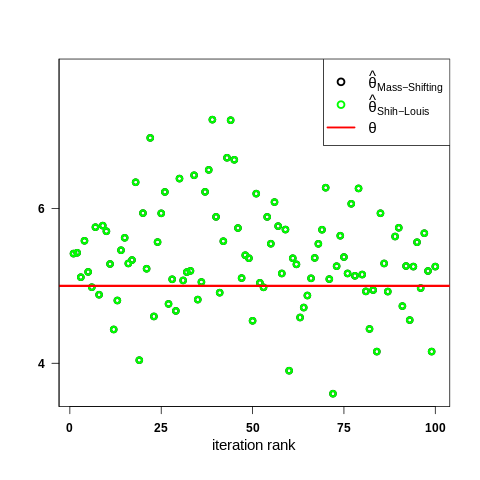

In [16]:
%%R
Xlabels = seq(from=0,to=Max,by=25)
Ylim = range(c(theta_hat_MassShift_vect,theta_hat_ShihLouis_vect))
Ylabels = seq(from=0,to=ceiling(Ylim[2]),length.out=5)

plot(theta_hat_MassShift_vect,lwd = 3,xlab="",ylab="",xaxt="none",yaxt="none",ylim=Ylim)
points(theta_hat_ShihLouis_vect,col='green',lwd = 3)
abline(h=theta,col='red',lwd = 3)

axis(1, at=Xlabels,labels=Xlabels,las=1,font=2)
axis(2, at=Ylabels,labels=Ylabels,las=1,font=2)
mtext(side=1, line=2.25, "iteration rank", font=1.5,cex=1.25)
legend("topright",legend=c(expression(hat(theta)[Mass-Shifting]),expression(hat(theta)[Shih-Louis]),expression(theta)),pch=c(1,1,NA),lwd = 2.5,col=c("black","green","red"),lty=c(NA,NA,1),cex=1.25)#,bty="n"

In [ ]:
%%R
cbind(theta_hat_MassShift_vect,theta_hat_ShihLouis_vect)

In [62]:
%%R
theta_hat <- theta_hat_MassShift_vect[Max]

Variance

In [129]:
%%R
#Fun_VarMLE <- function(Z1,Z2,del,theta_hat,Fn1,Fn2,n){

# # Variance of An

Fn1[Fn1==0] <- min(Fn1[Fn1!=0])/10 # values of 0 cause numerical issues
Fn2[Fn2==0] <- min(Fn2[Fn2!=0])/10 # values of 0 cause numerical issues

# Phi

Phi <- rep(1/(theta_hat+1),times=n)-
  log(Fn1[-(n+1)]*Fn2[-(n+1)])+
  rep(1/theta_hat**2,times=n)*log(Fn1[-(n+1)]**rep(-theta_hat,times=n)+Fn2[-(n+1)]**rep(-theta_hat,times=n)-1)+
  rep(2+1/theta_hat,times=n)*(Fn1[-(n+1)]**rep(-theta_hat,times=n)*log(Fn1[-(n+1)])+Fn2[-(n+1)]**rep(-theta_hat,times=n)*log(Fn2[-(n+1)]))/(Fn1[-(n+1)]**rep(-theta_hat,times=n)+Fn2[-(n+1)]**rep(-theta_hat,times=n)-1)

In [123]:
%%R

# VStar

A_z0 <- A_0z <- matrix(rep(NA,times=(n+1)*(n+1)),ncol=n+1)

A_z0[,n+1] <- 1
A_z0[n+1,] <- 1

A_0z[,n+1] <- 1
A_0z[n+1,] <- 1

for(i in 1:n){
    for(j in 1:n){
        A_z0[i,j] <- Z1[j]>=Z1[i]
        A_0z[i,j] <- Z2[j]>=Z2[i]
        #A[i,j] <- (Z1[j]>=Z1[i])*(Z2[j]>=Z2[i])
    }
}

b=c((1-eps)*del[1:n]/((1-eps)*(rsumA[1:n]-1)+eps*n),1)
B=diag(b)

Id = diag(1,n+1)

b=c((1-eps)*del[1:n]/((1-eps)*(rsumA[1:n]-1)+eps*n),1)
B=diag(b)

Id = diag(1,n+1)

M=rbind(Id-A_z0%*%B,-t(b))
MMinv=solve(t(M)%*%M)
Fbar=as.vector(MMinv%*%b)

Fbar=Fbar[-(n+1)]
b=b[-(n+1)]
A_z0=A_z0[-(n+1),][,-(n+1)]
B=B[-(n+1),][,-(n+1)]
Id=diag(1,n)
M=rbind(Id-A_z0%*%B,-t(b))
MMinv=solve(t(M)%*%M)

D=(1-A_z0)*(1-t(A_z0))*(A_z0%*%t(A_z0))
bf=b*Fbar
BF=diag(bf)
S=rbind(A_z0%*%BF,t(bf))
R=S%*%(Id+((B%*%D)%*%B))%*%t(S)
U=(t(M)%*%R)%*%M
V_z0=(MMinv%*%U)%*%MMinv

b=c((1-eps)*del[1:n]/((1-eps)*(rsumA[1:n]-1)+eps*n),1)
B=diag(b)

Id = diag(1,n+1)

M=rbind(Id-A_0z%*%B,-t(b))
MMinv=solve(t(M)%*%M)
Fbar=as.vector(MMinv%*%b)

Fbar=Fbar[-(n+1)]
b=b[-(n+1)]
A_0z=A_0z[-(n+1),][,-(n+1)]
B=B[-(n+1),][,-(n+1)]
Id=diag(1,n)
M=rbind(Id-A_0z%*%B,-t(b))
MMinv=solve(t(M)%*%M)

D=(1-A_0z)*(1-t(A_0z))*(A_0z%*%t(A_0z))
bf=b*Fbar
BF=diag(bf)
S=rbind(A_0z%*%BF,t(bf))
R=S%*%(Id+((B%*%D)%*%B))%*%t(S)
U=(t(M)%*%R)%*%M
V_0z=(MMinv%*%U)%*%MMinv

In [141]:
%%R
Fun_PhiStar <- function(x,y,theta){
  -1/x-
    rep(1/theta,times=n)*x**rep(-theta-1,times=n)/(x**rep(-theta,times=n)+y**rep(-theta,times=n)-1)+
    rep(2+1/theta,times=n)*x**rep(-theta-1,times=n)*((x**rep(-theta,times=n)+y**rep(-theta,times=n)-1)*(-rep(theta,times=n)*log(x)+1)+ 
                                                        rep(theta,times=n)*(x**rep(-theta,times=n)*log(x)+y**rep(-theta,times=n)*log(y)))/
    (x**rep(-theta,times=n)+y**rep(-theta,times=n)-1)**2
  }

PhiStar1 = Fun_PhiStar(x=Fn1[-(n+1)],y=Fn2[-(n+1)],theta=theta_hat)
PhiStar2 = Fun_PhiStar(x=Fn2[-(n+1)],y=Fn1[-(n+1)],theta=theta_hat)

PhiStar1_matrix = matrix(rep(PhiStar1,times=n),ncol=n)
PhiStar2_matrix = matrix(rep(PhiStar2,times=n),ncol=n)

In [143]:
%%R
VStar = V_z0*PhiStar1_matrix + V_0z*PhiStar2_matrix

# R_hat

az1=matrix(rep(Z1,n+1),ncol=n+1)
az2=matrix(rep(Z2,n+1),ncol=n+1)
A=(t(az1)>=az1)*(t(az2)>=az2)
A[lower.tri(A, diag = FALSE)] = 0
rsumA=apply(A,1,sum)

b=c((1-eps)*del[1:n]/((1-eps)*(rsumA[1:n]-1)+eps*n),1)
B=diag(b)

Id=diag(rep(1,n+1))
M=rbind(Id-A%*%B,-t(b))
MMinv=solve(t(M)%*%M)
Fbar=as.vector(MMinv%*%b)

Fbar=Fbar[-(n+1)]
b=b[-(n+1)]
A=A[-(n+1),][,-(n+1)]
B=B[-(n+1),][,-(n+1)]
Id=diag(1,n)
M=rbind(Id-A%*%B,-t(b))
MMinv=solve(t(M)%*%M)

D=(1-A)*(1-t(A))*(A%*%t(A))

Matrix1 = rbind(Id - A%*%B,-t(b))
Matrix2 = (rbind(A%*%B%*%diag(Fbar),b%*%diag(Fbar)))%*%(Id + B%*%D%*%B)%*%diag(Fbar)%*%B
Matrix3 = ginv(Matrix1)%*%Matrix2

r1_hat = Matrix3%*%(Phi*PhiStar1)
r2_hat = Matrix3%*%(Phi*PhiStar2)

In [ ]:
%%R

# e_hat

#Matrix5 = (rbind(A%*%B%*%diag(Fbar),b%*%diag(Fbar)))%*%(Id + B%*%D%*%B)%*%(diag(Fbar)%*%B%*%(Phi*Phi))

e_hat = Matrix3%*%(Phi*Phi)

# V (variance of Fbar)

V=(MMinv%*%U)%*%MMinv

# Var(An)

Var_An = t(PhiStar1)%*%diag(Fbar)%*%B%*%V%*%B%*%diag(Fbar)%*%PhiStar2+
  2*b%*%VStar%*%diag(Fbar)%*%b+
  2*t(r1_hat+r2_hat)%*%diag(Fbar)%*%b+
  t(Phi)%*%B%*%V%*%B%*%Phi+
  2*b%*%e_hat+
  t(Phi)%*%B%*%diag(Fbar)%*%(diag(Fbar)%*%b+B%*%D%*%B%*%diag(Fbar)%*%B%*%Phi)

# # Variance of sqrt(n)(theta_hat - theta)

#VarTheta = Var_An/(t(Phi)**2%*%Fbar)
VarTheta = Var_An/(t(Phi)**2%*%phat)

#  return(VarTheta)

#}

VarTheta

# CASdataset

In [ ]:
%%R
#canlifins <- get(load(file="/content/canlifins.rda"))

n=3000


#FunZDel_canlifins = function(size,seed=1){

#data(canlifins) # load the dataset
canlifins <- get(load('/content/canlifins.rda'))

#head(canlifins)

# 14,889 contracts where one annuitant is male and the other female

canlifins = canlifins[(canlifins$EntryAgeM>=18)|(canlifins$EntryAgeF>=18),]

seed <- 1
set.seed(seed)

Sample <- sample(1:dim(canlifins)[1],size = n)
canlifins <- canlifins[Sample,]

#head(canlifins)

#  c(
#    sum((canlifins$DeathTimeM == 0) & (canlifins$DeathTimeF == 0)), # number of doubly censored couples
#    sum((canlifins$DeathTimeM > 0) & (canlifins$DeathTimeF == 0)), # number of couples where only the woman is censored
#    sum((canlifins$DeathTimeM == 0) & (canlifins$DeathTimeF > 0)), # number of couples where only the man is censored
#    sum((canlifins$DeathTimeM > 0) & (canlifins$DeathTimeF > 0)) # number of doubly uncensored couples
#  )

#del1 = as.integer((canlifins$DeathTimeM > 0) & (canlifins$DeathTimeF == 0)) 
#del2 = as.integer((canlifins$DeathTimeM == 0) & (canlifins$DeathTimeF > 0))

del1 <- canlifins$DeathTimeM > 0
del2 <- canlifins$DeathTimeF > 0

#del = (canlifins$DeathTimeM > 0) * (canlifins$DeathTimeF > 0)

ordre <- order(canlifins$DeathTimeM+canlifins$EntryAgeM,canlifins$DeathTimeF+canlifins$EntryAgeF)
Z_ordered <- cbind(canlifins$DeathTimeM+canlifins$EntryAgeM,canlifins$DeathTimeF+canlifins$EntryAgeF)[ordre,]

del1 <- c(del1[ordre],1)
del2 <- c(del2[ordre],1)

xinf <- max(Z_ordered[,1],Z_ordered[,2])+1
Z1 <- c(Z_ordered[,1],xinf)
Z2 <- c(Z_ordered[,2],xinf)

#  return(list(Z1,Z2,del1,del2))
#}

del <- del1*del2

Graph of the dependence between the two lifetimes

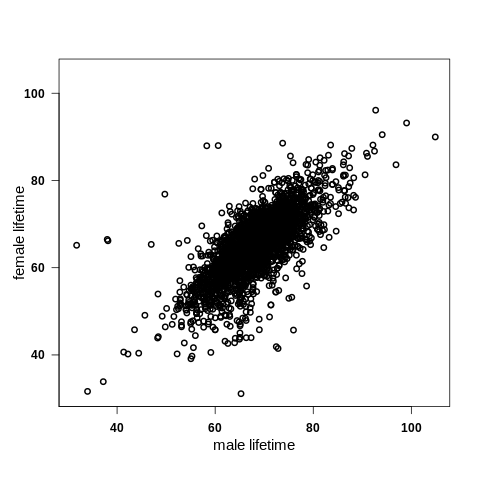

In [ ]:
%%R
# Graph of the dependence between the two lifetimes

Xlabels = Ylabels = seq(from=0,to=110,by=20)
Xlim = Ylim = range(c(Z1[-(n+1)],Z2[-(n+1)]))
par(mfrow=c(1,1))
plot(Z1[-(n+1)],Z2[-(n+1)],lwd = 2,xlab="",ylab="",xaxt="none",yaxt="none",xlim=Xlim,ylim=Ylim)
axis(1, at=Xlabels,labels=Xlabels,las=1,font=2)
axis(2, at=Ylabels,labels=Ylabels,las=1,font=2)
mtext(side=1, line=2.25, "male lifetime", font=1,cex=1.25)
mtext(side=2, line=2.25, "female lifetime", font=1,cex=1.25)

MLEs

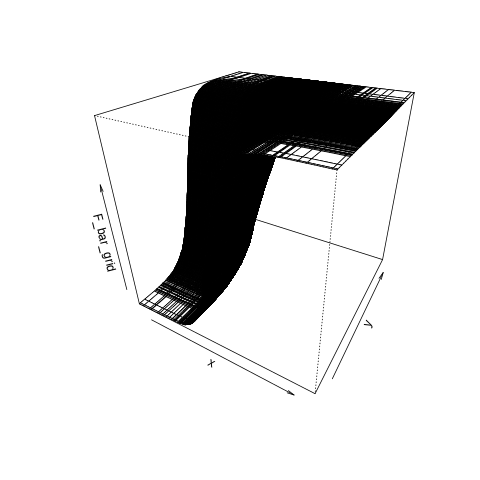

In [ ]:
%%R
# Phat and Fbar

az1=matrix(rep(Z1,n+1),ncol=n+1)
az2=matrix(rep(Z2,n+1),ncol=n+1)
A=(t(az1)>=az1)*(t(az2)>=az2)
# Because of ties, A may not be quite upper triangular. We need to convert some numbers to 0.
A[lower.tri(A, diag = FALSE)] = 0
rsumA=apply(A,1,sum)

eps=1/(n+1)

b=c((1-eps)*del[1:n]/((1-eps)*(rsumA[1:n]-1)+eps*n),1)
B=diag(b)

Id=diag(rep(1,n+1))
M=rbind(Id-A%*%B,-t(b))
MMinv=solve(t(M)%*%M)
Fbar=as.vector(MMinv%*%b) ### <---- THIS IS THE \bar{F} VECTOR
phat=(ginv(A)%*%Fbar)#[-(n+1)] # weights

phat = phat[-(n+1)]
Fbar=Fbar[-(n+1)]

# # Graph of Fbar: (not good for n=200,500, good for n=100,300)

FBarFun = function(x,y){
  sum(phat[((Z1 >= x)*(Z2 >= y))])
}

x = unique(Z1[order(Z1)])
y = unique(Z2[order(Z2)])
F_bar_grid <- outer(X=x,Y=y, FUN=Vectorize(FBarFun))

persp(x,y,F_bar_grid, theta = 30, phi = 30)

In [ ]:
%%R
# #  Pseudo-likelihood (mass-shifting) maximization

#Fun_ThetaHatFn12 <- function(Z1,Z2,del1,del2,n,phat,Fbar){
  
#del = del1*del2

# Starting point of Newton-Raphson

Tau_hat = 4*(t(phat) %*% Fbar)-1
Theta0 = 2*Tau_hat/(1-Tau_hat) # Clayton
#Theta0 = 1+4(incgam(3,1.2)/)

#s = 10**(-3)

# # # MLE of theta

# # Fn1

# az1=matrix(rep(Z1,n+1),ncol=n+1)
# A=t(az1)>=az1

# A[lower.tri(A, diag = FALSE)] = 0
# rsumA=apply(A,1,sum)

# b=c((1-eps)*del[1:n]/((1-eps)*(rsumA[1:n]-1)+eps*n),1)
# B=diag(b)

# Id = diag(1,n+1)

# M=rbind(Id-A%*%B,-t(b))
# MMinv=solve(t(M)%*%M)
# Fn1bar=as.vector(MMinv%*%b) # Fn1 bar
# Fn1 = 1-Fn1bar # Fn1
# #Fn1[Fn1 < s]=s # too small values will yield infinity when inverted

# # Fn2

# Z2_ordered = Z2[order(Z2)]
# az2=matrix(rep(Z2_ordered,n+1),ncol=n+1)
# A=t(az2)>=az2

# A[lower.tri(A, diag = FALSE)] = 0
# rsumA=apply(A,1,sum)

# del2 = del[order(Z2)]
# b=c((1-eps)*del2[1:n]/((1-eps)*(rsumA[1:n]-1)+eps*n),1)
# B=diag(b)

# M=rbind(Id-A%*%B,-t(b))
# MMinv=solve(t(M)%*%M)
# Fn2bar=as.vector(MMinv%*%b)
# Fn2 = 1-Fn2bar
# #Fn2[Fn2 < s]=s

# # MLE estimate of theta
# # theta_hat[i] = optimise(f=LogL,interval=c(0,10**2),maximum = TRUE)$maximum

# Fn1=Fn1[-(n+1)]
# Fn2=Fn2[-(n+1)]

Fn1bar <- survfit(Surv(Z1, del1) ~ 1)$surv
Fn1 <- 1-Fn1bar #*n/(n+1)
Fn2bar <- survfit(Surv(Z2, del2) ~ 1)$surv
Fn2 <- 1-Fn2bar #*n/(n+1)

Fn1[Fn1==0] <- min(Fn1[Fn1!=0])
Fn2[Fn2==0] <- min(Fn2[Fn2!=0])

In [ ]:
%%R

# Pseudo-likelihood function

L <- function(theta){ # for nlm function. Taking -1*likelilhood because nlm minimizes.
    -prod(((theta+1)*(Fn1*Fn2)**(-theta-1)*(Fn1**(-theta)+Fn2**(-theta)-1)**(-2-1/theta))**phat)
}

L_ShihLouis <- function(theta){ # for nlm function. Taking -1*likelilhood because nlm minimizes.
    -prod((theta+1)*(Fn1bar*Fn2bar)**(-theta-1)*(Fn1bar**(-theta)+Fn2bar**(-theta)-1)**(del1*del1)*
          Fn1bar**(-theta-1)*(Fn1bar**(-theta)+Fn2bar**(-theta)-1)**(-1/theta-1)*
          Fn2bar**(-theta-1)*(Fn1bar**(-theta)+Fn2bar**(-theta)-1)**(-1/theta-1)*
          (Fn1bar**(-theta)+Fn2bar**(-theta)-1)**(-1/theta))
}

# # Log-pseudo-likelihood function derivative aka score function
# DiffLogL <- function(x){ # Clayton
#   #x = 10
#   sum(phat*(rep(1/(x+1),times=n)-
#               log(Fn1*Fn2)+
#               (rep(1/x**2,times=n))*log(Fn1**(rep(-x,times=n))+Fn2**(rep(-x,times=n))-1)+
#               (rep(2+1/x,times=n))*(Fn1**(rep(-x,times=n))*log(Fn1)+ 
#               # this last term (the line above + the 2 below) has limit log(a)(log(b)+2)+2log(b)
#                                             Fn2**(rep(-x,times=n))*log(Fn2))/
#                                     (Fn1**(rep(-x,times=n))+Fn2**(rep(-x,times=n))-1)),na.rm=TRUE)
# }

# # Log-full-likelihood function derivative
# DiffLogLStar <- function(x){ # Clayton
#   #x = 10
#   sum(del1*del2*(rep(1/(x+1),times=n)-log(Fn1*Fn2))-
#               (del1*(1-del2)*log(Fn1)+(1-del1)*del2*log(Fn2))-
#               (
#                 -rep(1/x**2,times=n)*(1-del1*del2)*log(Fn1**(rep(-x,times=n))+Fn2**(rep(-x,times=n))-1)+
#                 (rep(1/x,times=n)*(1-del1*del2)+del1+del2-2*del1*del2)*((-Fn1**(rep(-x,times=n))*log(Fn1)-Fn2**(rep(-x,times=n))*log(Fn2))/(Fn1**(rep(-x,times=n))+Fn2**(rep(-x,times=n))-1))
#               )
#               ,na.rm=TRUE)
# }
  
#X=matrix(seq(from=0,to=15,by=0.01)); ForPlot=apply(X=X,MARGIN=1,FUN=DiffLogL);
#plot(X,ForPlot,type='l',ylim=range(c(ForPlot,0)));abline(h=0);

#  DiffLogL = function(x){ # 4.2.20 Nelsen
#    (-1/x)*sum(phat*((-exp(Fn1**(-rep(-x,times=n)))*Fn1**(-rep(-x,times=n))*log(Fn1)-exp(Fn2**(-rep(-x,times=n)))*Fn2**(-rep(-x,times=n))*log(Fn2))/
#      ((exp(Fn1**(-rep(-x,times=n)))+exp(Fn2**(-rep(-x,times=n)))-exp(1))*log(exp(Fn1**(-rep(-x,times=n)))+exp(Fn2**(-rep(-x,times=n)))-exp(1)))))
#  }

In [ ]:
%%R
X <- matrix(seq(from=0.1,to=15,by=0.1),ncol=1)
Y <- apply(X=X,MARGIN=1,FUN=L_ShihLouis)
#c(length(X),length(Y))
plot(X,Y,type='l')
#lines(X,rep(0,times=dim(X)[1]),col="red")

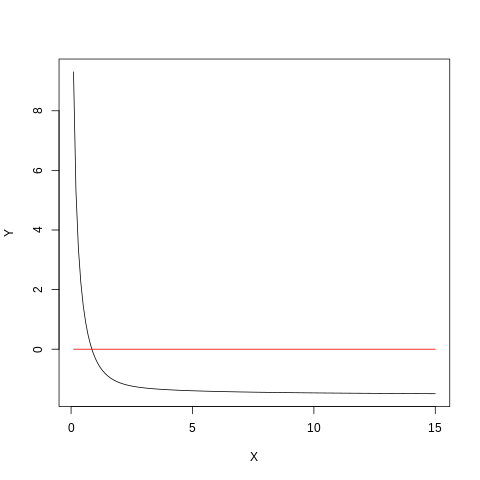

In [ ]:
%%R
X <- matrix(seq(from=0.1,to=15,by=0.1),ncol=1)
Y <- apply(X=X,MARGIN=1,FUN=DiffLogL)
plot(X,Y,type='l')
lines(X,rep(0,times=dim(X)[1]),col="red")

In [ ]:
%%R
theta_hat_MassShift <- nlm(f=L_ShihLouis, p=Theta0)$estimate
theta_hat_MassShift

[1] 3.898712


In [ ]:
%%R
#theta_hat_ShihLouis = uniroot(f=DiffLogLStar, interval=c(0.01,15))$root # not working
theta_hat_ShihLouis  <- nlm(f=DiffLogLStar, p=Theta0)$estimate
#theta_hat  <- nlm(f=DiffLogL, p=Theta0)$estimate

# Coding Newton-Raphson:
# https://rpubs.com/aaronsc32/newton-raphson-method#:~:text=%23%23%20%5B1%5D%203.162278-,Newton%2DRaphson%20Method%20in%20R,rootSolve%20package%20features%20the%20uniroot.

#  return(list(theta_hat_MassShift,theta_hat_ShihLouis,Fn1,Fn2))#
}# 

theta_hat_MassShift <- Fun_ThetaHatFn12(Z1,Z2,del1,del2,n,phat,Fbar)[[1]]

# # Full likelihood (ShihLouis) maximization

#theta_hat_ShihLouis = Fun_ThetaHatFn12(Z1,Z2,del1,del2,n,phat,Fbar)[[2]]

[1] 0.8426491
